In [1]:
import torch

from botorch.utils.multi_objective import is_non_dominated
from botorch.test_functions.multi_objective import DTLZ2, GMM

from scalarize.utils.scalarization_functions import LengthScalarization
from scalarize.utils.scalarization_parameters import UnitVector

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["mathtext.fontset"] = "stix"
matplotlib.rcParams["font.family"] = "STIXGeneral"
matplotlib.rcParams[
    "text.latex.preamble"
] = r"\usepackage{amsmath}\usepackage{amssymb}\usepackage{color}"

In [2]:
tkwargs = {"dtype": torch.double, "device": "cpu"}


def get_xy_front(ref_point, upper_front, lower_front):

    uf = upper_front[upper_front[:, 0].argsort()]
    lf = lower_front[lower_front[:, 0].argsort()]

    z = torch.linspace(ref_point[0], uf[-1, 0], 1000, **tkwargs)

    upper = torch.zeros(len(z), **tkwargs)
    lower = torch.zeros(len(z), **tkwargs)

    for i in range(len(z)):
        dist = (uf[:, 0] - z[i]) ** 2
        upper[i] = uf[dist.argmin()][-1]

        if z[i] < lf[-1, 0]:
            dist = (lf[:, 0] - z[i]) ** 2
            lower[i] = lf[dist.argmin()][-1]
        else:
            lower[i] = ref_point[1]

    return z, upper, lower

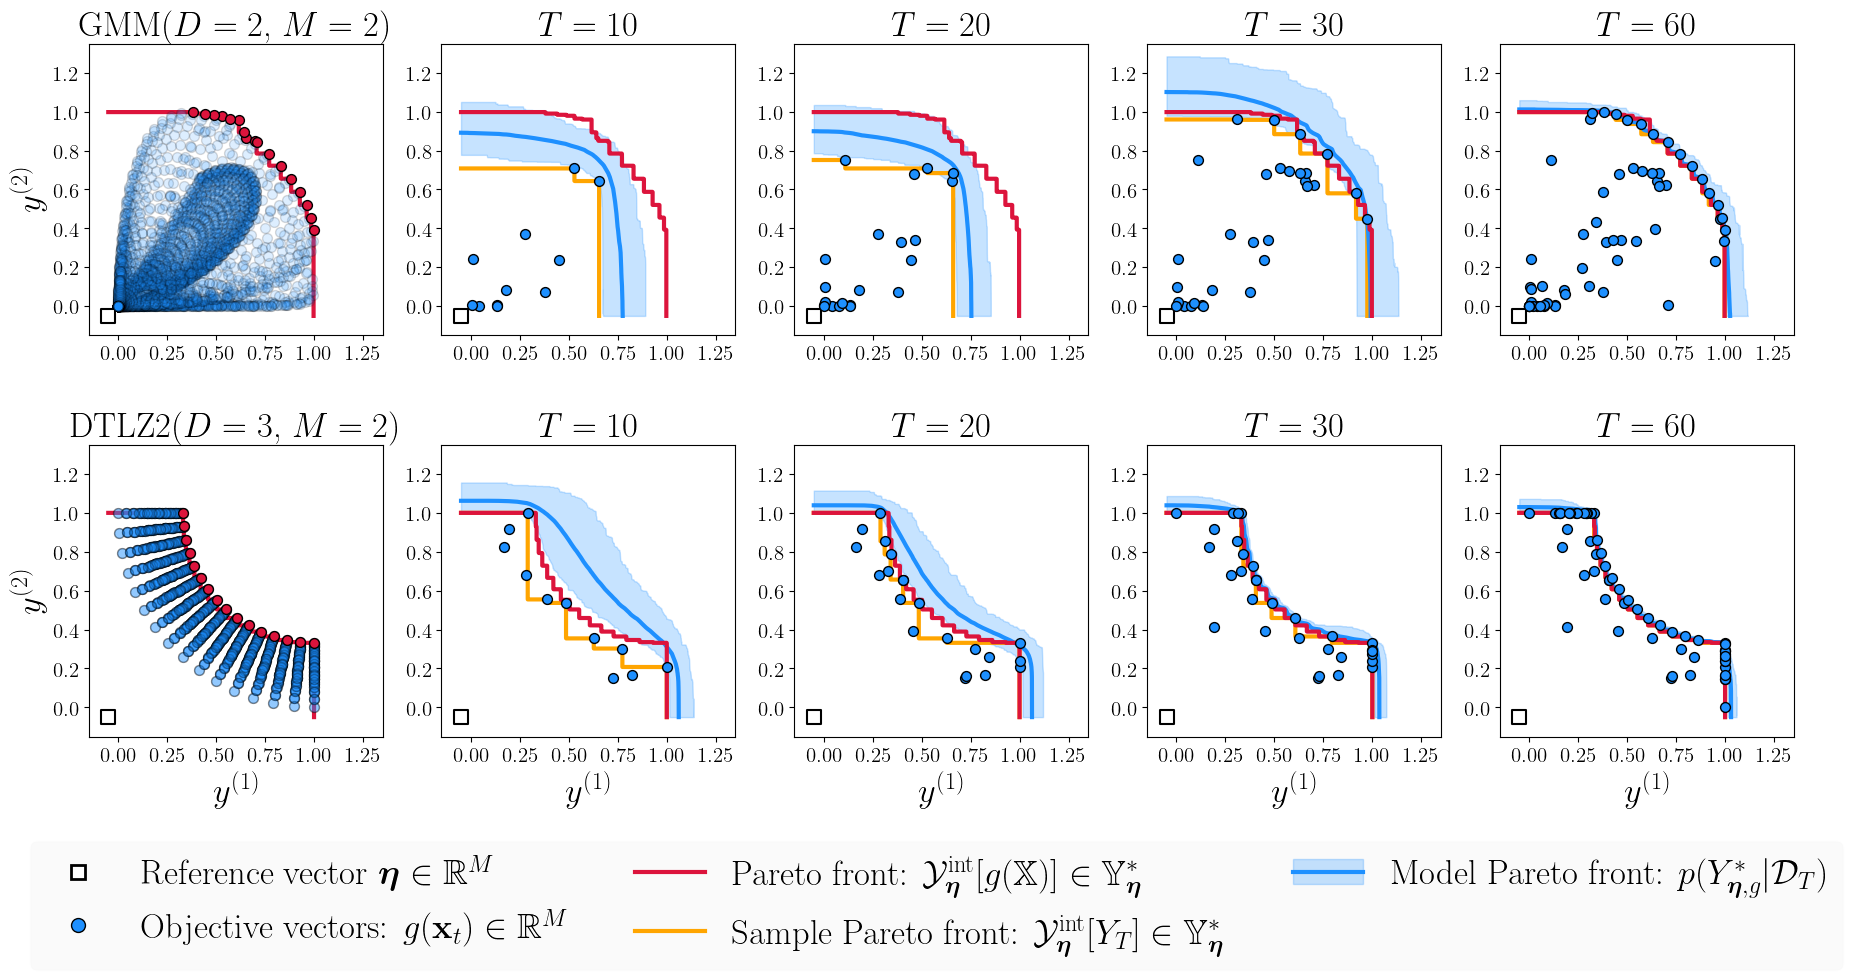

In [3]:
num_columns = 5
num_rows = 2
ts = [10, 20, 30, 60]

fig, axes = plt.subplots(num_rows, num_columns, figsize=(22, 9), rasterized=True)

plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.375
)

titles = [rf"GMM($D=2$, $M=2$)", rf"DTLZ2($D=3$, $M=2$)"]
problem_names = ["gmm2", "dtlz2"]

for row in range(num_rows):
    data = torch.load(f"data/{problem_names[row]}_plot_data.pt")
    ref_point = data["ref_point"]
    pareto_fX = data["pareto_fX"]
    not_pareto_fX = data["not_pareto_fX"]
    interpolated_front = data["interpolated_front"]
    sample_fronts = data["sample_fronts"]
    q95_fronts = data["q95_fronts"]
    q05_fronts = data["q05_fronts"]
    mean_fronts = data["mean_fronts"]
    Y = data["Y"]

    for i in range(num_columns):
        j = row * num_columns + i

        plt.subplot(num_rows, num_columns, j + 1)
        plt.scatter(
            ref_point[0],
            ref_point[1],
            color="w",
            marker="s",
            linestyle="None",
            s=100,
            edgecolors="k",
            linewidth=1.5,
            zorder=5,
        )
        if i == 0:
            plt.ylabel(r"$y^{(2)}$", fontsize=25)

        if row == 1:
            plt.xlabel(r"$y^{(1)}$", fontsize=25)

        plt.xlim([-0.15, 1.35])
        plt.ylim([-0.15, 1.35])
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)

    j = row * num_columns + 1
    plt.subplot(num_rows, num_columns, j)
    plt.scatter(
        not_pareto_fX[:, 0],
        not_pareto_fX[:, 1],
        color="dodgerblue",
        edgecolor="k",
        alpha=0.15,
        s=50,
        zorder=5,
    )
    plt.scatter(
        pareto_fX[:, 0],
        pareto_fX[:, 1],
        color="crimson",
        edgecolor="k",
        alpha=1,
        s=50,
        zorder=5,
    )

    plt.plot(
        interpolated_front[:, 0], interpolated_front[:, 1], color="crimson", linewidth=3
    )
    plt.title(titles[row], fontsize=25)

    for i, t in enumerate(ts):
        j = row * num_columns + i + 2
        plt.subplot(num_rows, num_columns, j)
        Yt = Y[0 : t + 1]

        # Sample front.
        plt.plot(
            sample_fronts[t, :, 0], sample_fronts[t, :, 1], color="orange", linewidth=3
        )

        # Plot front distribution.
        z, up, lo = get_xy_front(
            ref_point=ref_point,
            upper_front=q95_fronts[t - 1, ...],
            lower_front=q05_fronts[t - 1, ...],
        )

        plt.fill_between(z, up, lo, color="dodgerblue", alpha=0.25)
        plt.plot(
            mean_fronts[t - 1, :, 0],
            mean_fronts[t - 1, :, 1],
            color="dodgerblue",
            linewidth=3,
        )

        plt.scatter(
            Yt[:, 0],
            Yt[:, 1],
            color="dodgerblue",
            edgecolor="k",
            s=50,
            zorder=5,
            alpha=1,
        )
        plt.plot(
            interpolated_front[:, 0],
            interpolated_front[:, 1],
            color="crimson",
            linewidth=3,
        )
        plt.title(rf"$T={t}$", fontsize=25)

####################################################################################
# Legend.
white_square = mlines.Line2D(
    [],
    [],
    color="w",
    marker="s",
    linestyle="None",
    markersize=10,
    markeredgecolor="k",
    markeredgewidth=2,
    label=r"Reference vector: $\boldsymbol{\eta} \in \mathbb{R}^M$",
)

blue_dot = mlines.Line2D(
    [],
    [],
    color="dodgerblue",
    marker="o",
    linestyle="None",
    markeredgecolor="k",
    markersize=10,
)

green_line = mlines.Line2D([], [], color="dodgerblue", linestyle="-", linewidth=3)
green_patch = mpatches.Patch(color="dodgerblue", alpha=0.25)

red_line = mlines.Line2D([], [], color="crimson", linestyle="-", linewidth=3)
orange_line = mlines.Line2D([], [], color="orange", linestyle="-", linewidth=3)


labels = [
    r"Reference vector $\boldsymbol{\eta} \in \mathbb{R}^M$",
    r"Objective vectors: $g(\mathbf{x}_t) \in \mathbb{R}^M$",
    r"Pareto front: $\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[g(\mathbb{X})] \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
    r"Sample Pareto front: $\mathcal{Y}_{\boldsymbol{\eta}}^{\text{int}}[Y_T] \in \mathbb{Y}^*_{\boldsymbol{\eta}}$",
    r"Model Pareto front: $p(Y_{\boldsymbol{\eta}, g}^*|\mathcal{D}_T)$",
]

axes[1, 0].legend(
    handles=[
        (white_square),
        (blue_dot),
        (red_line),
        (orange_line),
        (green_line, green_patch),
    ],
    labels=labels,
    ncol=3,
    fontsize=25,
    loc=(-0.2, -0.8),
    facecolor="k",
    framealpha=0.02,
)

plt.show()